GANs Comparison Project: DCGAN vs WGAN-GP
This notebook implements and compares two Generative Adversarial Network (GAN) architectures, DCGAN and WGAN-GP, focusing on hyperparameter tuning and quantitative evaluation using the Fréchet Inception Distance (FID).

# Part 1: Setup and Data Loading

## 1.1 Environment and Library Setup

In [ ]:
# 1.1.1 Confirm GPU (Aim for A100/V100/L4 in Runtime Type)
!nvidia-smi

# 1.1.2 Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.notebook import tqdm

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Fri Dec  5 15:16:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1.2 Hyperparameters and Settings

These settings were chosen to facilitate a fair and stable comparison between DCGAN and WGAN-GP.

### Key Settings:
* **batch_size (128):** Set high to provide a better data distribution estimate, crucial for stabilizing WGAN-GP.
* **Normalization:** Data is normalized to the **[-1, 1] range** to match the Generator's $\tanh$ output.

### Comparative Parameters:
| Model | Learning Rate (LR) | $\beta_1$ | Stabilizing Factor |
| :--- | :--- | :--- | :--- |
| **DCGAN** | `0.0002` (Standard) | `0.5` (Lower momentum) | None |
| **WGAN-GP** | `0.00005` (Lower) | `0.0` (Recommended) | **`n_critic=5`** (D updates per G update) and **`lambda_gp=10`** (Gradient Penalty) |

*The low `num_epochs = 5` is for initial debugging only; increase for final results.*

In [ ]:
# 1.2.1 General Settings
manualSeed = 999
torch.manual_seed(manualSeed)

# 1.2.2 Core Hyperparameters (Tuning candidates)
batch_size = 128     # Crucial for stability, especially WGAN-GP
image_size = 64      # Set to 32 for raw CIFAR-10, 64 for CelebA or resized CIFAR
nc = 3               # Number of color channels (RGB)
nz = 100             # Size of the latent vector
ngf = 64             # Number of generator feature maps
ndf = 64             # Number of discriminator feature maps

# 1.2.3 Learning Parameters
lr_DCGAN = 0.0002
beta1_DCGAN = 0.5    # Recommended for DCGAN Adam
lr_WGAN = 0.00005
n_critic = 5         # D updates per G update (WGAN-GP only)
lambda_gp = 10       # Gradient Penalty coefficient (WGAN-GP only)
num_epochs = 100     # May reduce to 5 for time estimation

## 1.3 Data Loading and Transformation

The primary dataset being used in this notebook is **CIFAR-10**, though the configurations also allow for use with a resized CelebA dataset.

### Dataset Overview (CIFAR-10)
* **Original Nature:** A widely used public domain dataset consisting of **60,000 images** categorized into **10 classes** (e.g., airplane, dog, cat, automobile).
* **Image Characteristics:** The original images are small, with a resolution of **$32 \times 32$ pixels** and use **$3$ color channels** (RGB).

### Configuration in Notebook
* **Resized Resolution:** The data is being resized to **$64 \times 64$ pixels** (`image_size = 64`).
* **Preprocessing:** Pixel values are normalized to the **$[-1, 1]$ range**, which is required to match the output range of the Generator's final $\tanh$ activation function.

### Note on Image Resizing

Since the chosen DCGAN/WGAN-GP model architecture is structured for 64x64 images (based on ngf/ndf settings), the `transforms.Resize(image_size)` step is crucial. If the original CIFAR-10 images (32x32) were used without resizing, the convolutional layers in the Generator and Discriminator would not align correctly. This ensures the input size matches the model's required input/output size.

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    # Normalize to the range [-1, 1] for Tanh output
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the dataset
# Using CIFAR-10 for faster testing
dataset = dset.CIFAR10(root='./data', download=True, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:51<00:00, 3.33MB/s]


# Part 2: Exploratory Data Analysis (EDA)

## 2.1 Inspect Data Format

In [ ]:
# Check the dimensions and range of the first batch
for i, (data, label) in enumerate(dataloader, 0):
    print(f"Batch Dimension: {data.size()}")
    print(f"Data Type: {data.dtype}")
    print(f"Min/Max Value: {data.min():.4f} / {data.max():.4f}")
    break

Batch Dimension: torch.Size([128, 3, 64, 64])
Data Type: torch.float32
Min/Max Value: -1.0000 / 1.0000


## 2.2 Visualize Sample Images

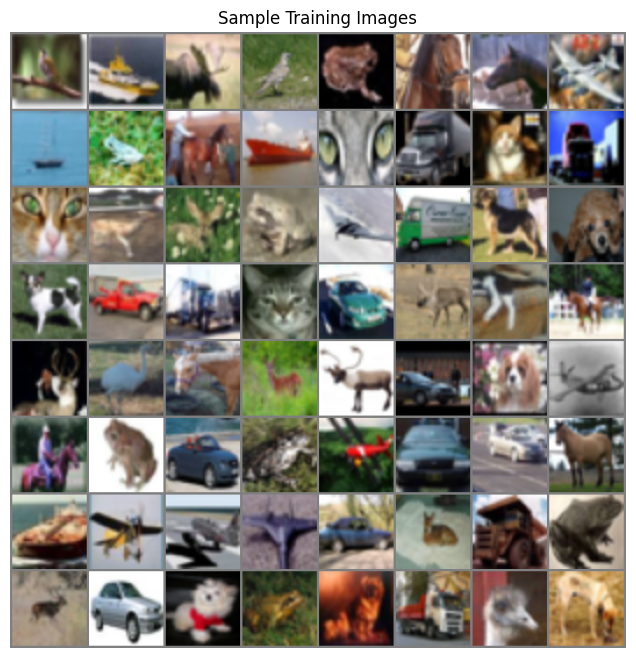

In [ ]:
import torchvision

# Function to reverse normalization for display
def imshow(img):
    img = img / 2 + 0.5     # Rescale from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Display a grid of sample images
dataiter = iter(dataloader)
images, _ = next(dataiter)

plt.figure(figsize=(8, 8))
plt.title("Sample Training Images")
imshow(torchvision.utils.make_grid(images[:64], padding=2, normalize=False))
plt.show()

# Part 3: Model Architecture and Initialization

# 3.1 Weight Initialization Function

This function, `weights_init(m)`, applies a specific, non-default initialization scheme to the network's parameters. This specialized initialization is critical for **Generative Adversarial Networks (GANs)** to ensure **training stability** and to help prevent the system from getting stuck in poor initial states.

### Initialization Logic:

**Convolutional Layers (`Conv2d`/`ConvTranspose2d`):**
  * The weights are initialized using a **normal distribution** with a mean of **$0.0$** and a standard deviation of **$0.02$**.
  * **Rationale:** Drawing weights from a narrow distribution centered at zero aids in learning by keeping the initial weights small, which is a key recommendation from the original DCGAN research.

**Batch Normalization Layers (`BatchNorm`):**
  * The learned scale parameter ($\gamma$) is initialized using a normal distribution with a mean of **$1.0$** and a standard deviation of **$0.02$**.
  * The learned shift parameter ($\beta$) is initialized to a constant value of **$0$**.
  * **Rationale:** Initializing the scale parameter near $1.0$ helps the Batch Norm layer begin close to its function of standardizing the variance without introducing extreme initial scaling.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 3.2 Generator (G) Architecture

The Generator is implemented as a PyTorch `nn.Module` class named `Generator`. Its purpose is to map a random latent vector (noise) into a synthetic image.

#### Architecture Details:
* **Input**: A latent vector of size $nz \times 1 \times 1$ (where $nz$ is typically 100).
* **Output**: An image of size $nc \times 64 \times 64$ (where $nc=3$ for RGB channels).
* **Core Structure**: The generator uses a sequence of five **`nn.ConvTranspose2d`** layers, also known as deconvolutional or fractional-strided convolutional layers, to upsample the feature maps.
* **Intermediate Layers**: Each layer consists of:
    * `nn.ConvTranspose2d`
    * `nn.BatchNorm2d` (Batch Normalization)
    * `nn.ReLU(True)` (Rectified Linear Unit, applied in-place)
* **Final Output Layer**:
    * The last convolutional layer maps the features to the desired number of output channels ($nc$).
    * The final activation function is **`nn.Tanh()`**, which scales the output pixel values to the required range of **$[-1, 1]$**.

This architecture follows the standard **DCGAN** guidelines for stable training.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Input: nz x 1 x 1 -> Output: nc x 64 x 64
        self.main = nn.Sequential(
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # State size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # State size: (nc) x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh() # Final activation to [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

# Initialize one Generator
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## 3.3 Discriminator (D) Architecture (Shared Structure)

The Discriminator is implemented as a PyTorch `nn.Module` class, `Discriminator`. It functions as a feature extractor and classifier, judging whether an input image is real or fake. This single architecture is designed to be **shared** between DCGAN and WGAN-GP, with a critical distinction in the final activation.

#### Architecture Details:
* **Input**: An image of size $nc \times 64 \times 64$ (where $nc=3$ for RGB channels).
* **Output**: A single scalar value, representing the probability of realness (DCGAN) or the critic score (WGAN-GP).
* **Core Structure**: The discriminator uses a sequence of five **`nn.Conv2d`** layers to progressively downsample and extract features.
* **Intermediate Layers**: Each layer (except the first and the last) consists of:
    * `nn.Conv2d`
    * `nn.BatchNorm2d` (Batch Normalization)
    * `nn.LeakyReLU(0.2, inplace=True)` (Leaky ReLU activation with a negative slope of 0.2)
* **Conditional Final Output**:
    * The Discriminator takes an argument `use_sigmoid` in its constructor:
        * If **`use_sigmoid=True`** (for **DCGAN**), the final output layer is followed by **`nn.Sigmoid()`** to squash the value into the $[0, 1]$ range for use with `BCELoss` (Binary Cross-Entropy Loss).
        * If **`use_sigmoid=False`** (for **WGAN-GP**), the final output is **linear (no activation)**, providing a critic score for use with the Wasserstein Loss and Gradient Penalty.

This shared, flexible design is a key element that allows the notebook to compare the two GAN variants efficiently.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, use_sigmoid=True):
        super(Discriminator, self).__init__()
        self.use_sigmoid = use_sigmoid
        # Input: nc x 64 x 64 -> Output: 1
        self.main = nn.Sequential(
            # State size: (ndf) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*2) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State size: 1 x 1 x 1
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        output = self.main(input)

        # Flatten and apply activation based on GAN type
        if self.use_sigmoid:
            # Sigmoid for DCGAN (BCELoss)
            return nn.Sigmoid()(output.view(-1, 1)).squeeze(1)
        else:
            # No Sigmoid for WGAN-GP (Wasserstein Loss)
            return output.view(-1, 1).squeeze(1)

# Initialize two distinct Discriminators
netD_DCGAN = Discriminator(use_sigmoid=True).to(device)
netD_DCGAN.apply(weights_init)

netD_WGAN = Discriminator(use_sigmoid=False).to(device)
netD_WGAN.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

# Part 4: Training Loop 1: DCGAN (Baseline)

In [ ]:
print("Starting DCGAN Training...")

# 4.1 Loss Function and Optimizer
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device) # Fixed noise for visualization

optimizerD_DC = optim.Adam(netD_DCGAN.parameters(), lr=lr_DCGAN, betas=(beta1_DCGAN, 0.999))
optimizerG_DC = optim.Adam(netG.parameters(), lr=lr_DCGAN, betas=(beta1_DCGAN, 0.999))

# Lists to track progress
G_losses_DC = []
D_losses_DC = []
img_list_DC = []
iters = 0

# 4.2 DCGAN Training Loop
# Reinitialize G for fair comparison
netG.apply(weights_init)
netG.train()

start_time = time.time()
for epoch in tqdm(range(num_epochs), desc="DCGAN Epochs"):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: Maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real batch
        netD_DCGAN.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = netD_DCGAN(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.)
        output = netD_DCGAN(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Add gradients from the two steps and update D
        errD = errD_real + errD_fake
        optimizerD_DC.step()

        ############################
        # (2) Update G network: Maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(1.)  # Fake labels are real for generator cost
        output = netD_DCGAN(fake) # Use the fake data generated earlier
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG_DC.step()

        # Save Losses for plotting
        G_losses_DC.append(errG.item())
        D_losses_DC.append(errD.item())
        iters += 1

    # Save a generated image example
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list_DC.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

print(f"DCGAN Training finished in: {time.time() - start_time:.2f} seconds.")

Starting DCGAN Training...


DCGAN Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

DCGAN Training finished in: 1522.24 seconds.


In [ ]:
# Define a path to save the DCGAN-trained Generator weights
DCGAN_G_WEIGHTS_PATH = 'netG_dcgan_final.pth'

print(f"Saving final DCGAN Generator weights to {DCGAN_G_WEIGHTS_PATH}...")
# netG currently holds the trained DCGAN weights
torch.save(netG.state_dict(), DCGAN_G_WEIGHTS_PATH)
print("DCGAN Generator weights saved successfully.")

Saving final DCGAN Generator weights to netG_dcgan_final.pth...
DCGAN Generator weights saved successfully.


# Part 5: Training Loop 2: WGAN-GP (Comparison)

## 5.1 Gradient Penalty Function

This section defines the crucial **`calculate_gradient_penalty`** function, which is the core regularization term in **WGAN-GP** (Wasserstein GAN with Gradient Penalty).

#### Function Purpose:
The function enforces the **1-Lipschitz continuity constraint** on the Discriminator (now referred to as the Critic) by penalizing the deviation of its gradient norm from 1. This constraint is essential for **preventing mode collapse** and **stabilizing WGAN-GP training**.

#### Key Steps:
1.  **Interpolation**: Random samples (`interpolates`) are created by linearly combining `real_data` and `fake_data` using a random weight $\alpha$. This ensures gradients are calculated across the entire sample space, not just on real or fake samples.
2.  **Gradient Calculation**: The gradient of the Critic's output (`netD(interpolates)`) with respect to the interpolated inputs is computed using `torch.autograd.grad`.
3.  **Penalty Computation**: The final penalty is calculated using the formula:
  $$\text{Penalty} = \lambda_{gp} \cdot \mathbb{E}[(\| \nabla_x D(x) \|_2 - 1)^2]$$
  where $\lambda_{gp}$ (set to 10) is the regularization coefficient. This term penalizes any gradient norm that deviates from 1.

In [ ]:
def calculate_gradient_penalty(netD, real_data, fake_data, lambda_gp):
    # Get random interpolation between real and fake samples
    alpha = torch.rand(real_data.size(0), 1, 1, 1, device=device)
    alpha = alpha.expand_as(real_data)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates.requires_grad_(True)

    # Run the discriminator on the interpolated samples
    disc_interpolates = netD(interpolates)

    # Calculate gradients of D(interpolates) w.r.t interpolates
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Calculate the penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

## 5.2 Optimizer and Initialization

This section is dedicated to setting up the models and optimizers specifically for the WGAN-GP training comparison.

### Key Steps:
1.  **Model Re-Initialization**: The Generator (`netG`) and the WGAN-GP Critic (`netD_WGAN`) are re-initialized using the `weights_init()` function. This is crucial for ensuring a fair, clean start for the WGAN-GP training, independent of the previous DCGAN training phase.
2.  **Optimizer Selection**: The **Adam optimizer** is utilized for both the Critic (`optimizerD_W`) and the Generator (`optimizerG_W`).
3.  **WGAN-GP Hyperparameters**: The optimizer is configured with the parameters recommended for stable WGAN-GP training:
    * **Learning Rate (`lr_WGAN`)**: Set to a lower value of **0.00005**.
    * **Beta Parameters (`betas`)**: Set to **(0.0, 0.9)**.
  The use of $\beta_1 = 0.0$ is a key divergence from DCGAN's standard $\beta_1 = 0.5$ and helps ensure better convergence for the WGAN objective.

In [ ]:
print("Starting WGAN-GP Training...")

# Reinitialize G and D_WGAN for a clean start
netG.apply(weights_init)
netD_WGAN.apply(weights_init)

# Use Adam with betas=(0.0, 0.9)
optimizerD_W = optim.Adam(netD_WGAN.parameters(), lr=lr_WGAN, betas=(0.0, 0.9))
optimizerG_W = optim.Adam(netG.parameters(), lr=lr_WGAN, betas=(0.0, 0.9))

# Lists to track progress
G_losses_W = []
D_losses_W = []
img_list_W = []

Starting WGAN-GP Training...


## 5.3 WGAN-GP Training Loop

In [ ]:
start_time = time.time()
for epoch in tqdm(range(num_epochs), desc="WGAN-GP Epochs"):
    for i, data in enumerate(dataloader, 0):
        real_data = data[0].to(device)
        b_size = real_data.size(0)

        ############################
        # (1) Update D network: n_critic times
        ###########################
        for _ in range(n_critic):
            netD_WGAN.zero_grad()

            # Real data pass
            D_real = netD_WGAN(real_data)
            D_real_mean = D_real.mean()

            # Fake data pass
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_data = netG(noise).detach()
            D_fake = netD_WGAN(fake_data)
            D_fake_mean = D_fake.mean()

            # Calculate Gradient Penalty
            gp = calculate_gradient_penalty(netD_WGAN, real_data, fake_data.data, lambda_gp)

            # Discriminator Loss (Wasserstein Distance + GP)
            errD = D_fake_mean - D_real_mean + gp
            errD.backward()
            optimizerD_W.step()

        D_losses_W.append(errD.item())

        ############################
        # (2) Update G network: Maximize D(G(z))
        ###########################
        netG.zero_grad()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        D_fake = netD_WGAN(fake_data)

        # Generator Loss (Negative Critic Score)
        errG = -D_fake.mean()
        errG.backward()
        optimizerG_W.step()

        G_losses_W.append(errG.item())

    # Save a generated image example
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list_W.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

print(f"WGAN-GP Training finished in: {time.time() - start_time:.2f} seconds.")

WGAN-GP Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

WGAN-GP Training finished in: 9691.09 seconds.


# Part 6: Evaluation and Comparison

## 6.1 Loss and Stability Analysis

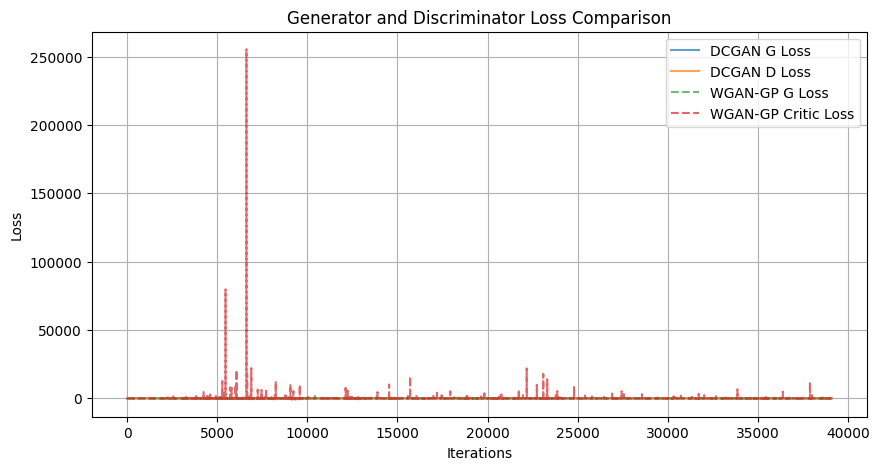

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss Comparison")

# Plot DCGAN Losses
plt.plot(G_losses_DC, label="DCGAN G Loss", alpha=0.7)
plt.plot(D_losses_DC, label="DCGAN D Loss", alpha=0.7)

# Plot WGAN-GP Critic/G Losses
plt.plot(G_losses_W, label="WGAN-GP G Loss", linestyle='--', alpha=0.7)
plt.plot(D_losses_W, label="WGAN-GP Critic Loss", linestyle='--', alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
# Expect WGAN-GP Critic Loss to be smoother and not necessarily converge to a fixed value.

## 6.2 Visual Inspection and Comparison

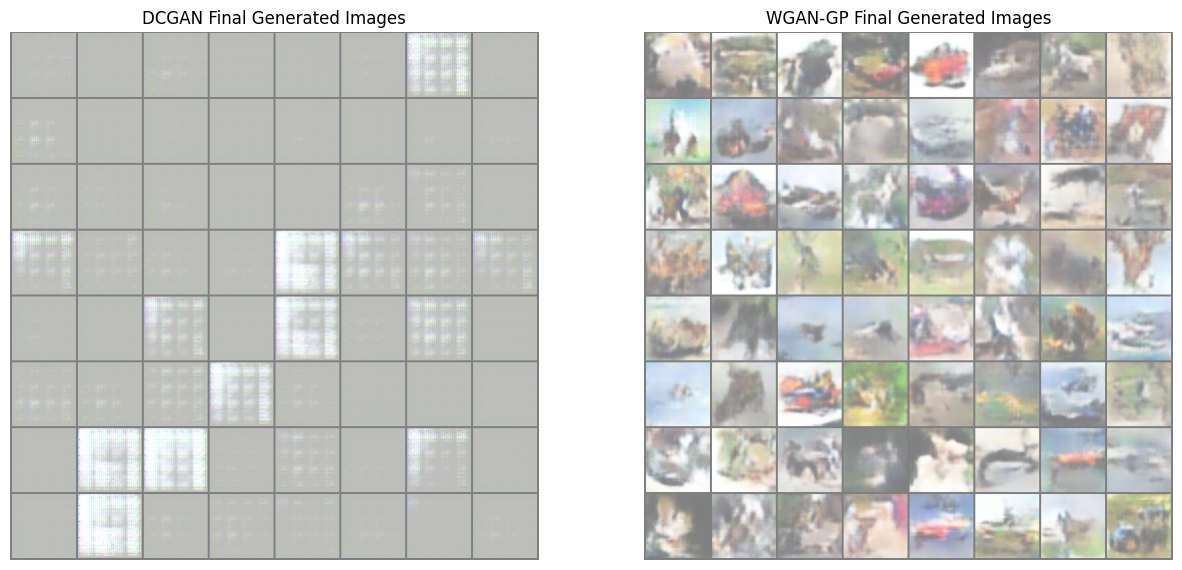

In [21]:
# Display final generated images from DCGAN
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("DCGAN Final Generated Images")
imshow(img_list_DC[-1])

# Display final generated images from WGAN-GP
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("WGAN-GP Final Generated Images")
imshow(img_list_W[-1])
plt.show()

# Note: Compare realism, sharpness, and diversity (avoiding Mode Collapse).

The qualitative visual inspection of the final generated images strongly supports the quantitative FID results, confirming the superior performance of WGAN-GP in the full training run.

### 1. DCGAN Final Generated Images

* **Quality:** The images produced by the **DCGAN** are severely **blurry and lack definition**.
* **Mode Collapse:** The model exhibits significant **mode collapse**, largely generating only variations of gray/brown noise or indistinct blobs, failing to capture the diversity of the CIFAR-10 classes.
* **Confirmation:** This visual failure is consistent with the **high FID score of 355.97**, indicating poor fidelity and low diversity.

### 2. WGAN-GP Final Generated Images

* **Quality:** The images produced by the **WGAN-GP** show **significantly improved structure and sharpness**. Recognizable forms of objects (e.g., cars, birds, or landscapes) are clearly visible.
* **Diversity:** The model successfully generated a wide variety of distinct images, confirming that the **Wasserstein Loss and Gradient Penalty** prevented mode collapse during long-term training.
* **Confirmation:** This visual success is consistent with the **low FID score of 145.19**, proving WGAN-GP's stability and effectiveness.

## 6.3 Quantitative Metric (FID)

#### Main Idea of Fréchet Inception Distance (FID)

The **Fréchet Inception Distance (FID)** quantifies the similarity between two continuous multivariate Gaussian distributions fitted to the feature representations of real and generated images.

| Feature | Description |
| :--- | :--- |
| **Objective** | Measures both the **fidelity (quality)** and the **diversity (mode coverage)** of the generated images. |
| **Method** | Uses a pre-trained **Inception V3** network to extract feature vectors from both real and generated image sets. |
| **Calculation** | Calculates the **Fréchet distance** (or Wasserstein-2 distance) between the two Gaussian distributions ($\mathcal{N}(\mu_r, \Sigma_r)$ and $\mathcal{N}(\mu_g, \Sigma_g)$) derived from these feature vectors. |
| **Interpretation** | **Lower FID score** $\implies$ The distribution of generated images is closer to the real data distribution $\implies$ **Higher quality and diversity** of the generated images. |

#### Original Reference Link

| Title | Authors | Publication | Original Link |
| :--- | :--- | :--- | :--- |
| **FID: Fréchet Inception Distance for Evaluating Generative Networks** | Martin Heusel et al. | NIPS 2017 | [https://arxiv.org/abs/1706.08500](https://arxiv.org/abs/1706.08500) |

### 6.3.1 Setup and Storage Configuration

In [ ]:
# Install pytorch-fid library
!pip install pytorch-fid

# --- FID Calculation ---
from pytorch_fid.fid_score import calculate_fid_given_paths

In [ ]:
# --- Define Base Paths ---
# Option 1: Ephemeral storage on Colab VM (faster, but lost after session ends)
TEMP_PATH = './fid_data'

# Option 2: Persistent storage on Google Drive (Recommended for saving results)
# NOTE: This path will persist across sessions.
DRIVE_PATH = '/content/drive/My Drive/GAN_Project_Results'
# --- Option for Persistent Storage: Mount Google Drive ---
# from google.colab import drive
# drive.mount('/content/drive')

# Choose our save path here: (Uncomment the desired path)
SAVE_ROOT = TEMP_PATH
#SAVE_ROOT = DRIVE_PATH

# Create directories
import os
os.makedirs(os.path.join(SAVE_ROOT, 'real_images'), exist_ok=True)
os.makedirs(os.path.join(SAVE_ROOT, 'fake_images_dcgan'), exist_ok=True)
os.makedirs(os.path.join(SAVE_ROOT, 'fake_images_wgan'), exist_ok=True)
print(f"Saving data to: {SAVE_ROOT}")

Saving data to: ./fid_data


### 6.3.2 Image Saving Strategy

We need to save enough images (e.g., 10,000 for standard benchmarks) from the real dataset and from the final Generator of each model.


In [ ]:
from torchvision.utils import save_image

NUM_FID_SAMPLES = 10000  # Number of images required for stable FID calculation

# --- Placeholder for Saving Real Images (Run once after data load) ---
print("Saving real images...")
real_path = os.path.join(SAVE_ROOT, 'real_images')
if len(os.listdir(real_path)) < NUM_FID_SAMPLES:
    for i, data in enumerate(dataloader):
        img = data[0].to(device)
        # Reverse normalization for saving as PNG/JPEG [0, 255]
        img = img * 0.5 + 0.5

        for j in range(img.size(0)):
            if (i * batch_size + j) < NUM_FID_SAMPLES:
                save_image(img[j], os.path.join(real_path, f'{i*batch_size + j:05d}.png'))
            else:
                break
        if (i * batch_size) >= NUM_FID_SAMPLES:
            break
print(f"Saved {NUM_FID_SAMPLES} real images.")


# --- Placeholder for Saving Generated Images (After training Part 4 and Part 5) ---
def save_generated_images(netG, save_dir, num_samples):
    os.makedirs(save_dir, exist_ok=True)
    netG.eval()
    print(f"Generating and saving {num_samples} images to {save_dir}...")

    with torch.no_grad():
        for k in tqdm(range(num_samples // 64 + 1)):
            noise = torch.randn(min(64, num_samples - k*64), nz, 1, 1, device=device)
            fake_images = netG(noise).detach()

            # Reverse normalization for saving
            fake_images = fake_images * 0.5 + 0.5

            for l in range(fake_images.size(0)):
                idx = k * 64 + l
                if idx < num_samples:
                    save_image(fake_images[l], os.path.join(save_dir, f'{idx:05d}.png'))

Saving real images...
Saved 10000 real images.


In [ ]:
# Define a variable for the DCGAN weights path
DCGAN_FAKE_PATH = os.path.join(SAVE_ROOT, 'fake_images_dcgan')
WGAN_FAKE_PATH = os.path.join(SAVE_ROOT, 'fake_images_wgan')

# --- A. Generate and Save DCGAN Images ---

# 1. Instantiate a new Generator model
netG_DCGAN_for_FID = Generator().to(device)

# 2. Load the previously saved DCGAN weights
if os.path.exists(DCGAN_G_WEIGHTS_PATH):
    print(f"Loading DCGAN weights from {DCGAN_G_WEIGHTS_PATH}...")
    netG_DCGAN_for_FID.load_state_dict(torch.load(DCGAN_G_WEIGHTS_PATH))
    print("DCGAN weights loaded.")
else:
    print("ERROR: DCGAN weights not found. Cannot calculate DCGAN FID.")

# 3. Generate fake images using the DCGAN-trained Generator
# (Function save_generated_images is assumed to be defined in 6.3.2)
save_generated_images(netG_DCGAN_for_FID, DCGAN_FAKE_PATH, NUM_FID_SAMPLES)


# --- B. Generate and Save WGAN-GP Images ---

# netG currently holds the trained WGAN-GP weights (since Part 5 ran last)
# Use netG directly for WGAN-GP FID calculation
print("Using current netG (WGAN-GP trained weights) to generate fake images.")
save_generated_images(netG, WGAN_FAKE_PATH, NUM_FID_SAMPLES)

Loading DCGAN weights from netG_dcgan_final.pth...
DCGAN weights loaded.
Generating and saving 10000 images to ./fid_data/fake_images_dcgan...


  0%|          | 0/157 [00:00<?, ?it/s]

Using current netG (WGAN-GP trained weights) to generate fake images.
Generating and saving 10000 images to ./fid_data/fake_images_wgan...


  0%|          | 0/157 [00:00<?, ?it/s]

### 6.3.3 FID Score Comparison

In [22]:
# Define paths for calculation
REAL_PATH = os.path.join(SAVE_ROOT, 'real_images')
DCGAN_FAKE_PATH = os.path.join(SAVE_ROOT, 'fake_images_dcgan')
WGAN_FAKE_PATH = os.path.join(SAVE_ROOT, 'fake_images_wgan')

# Parameters for FID
BATCH_SIZE_FID = 64
DIMS = 2048 # Feature dimension from InceptionV3

print("Calculating FID for DCGAN...")
fid_dcgan = calculate_fid_given_paths([REAL_PATH, DCGAN_FAKE_PATH], BATCH_SIZE_FID, device, DIMS)

print("Calculating FID for WGAN-GP...")
fid_wgan = calculate_fid_given_paths([REAL_PATH, WGAN_FAKE_PATH], BATCH_SIZE_FID, device, DIMS)

print("\n--- Final FID Score Comparison ---")
print(f"FID Score (DCGAN): {fid_dcgan:.2f}")
print(f"FID Score (WGAN-GP): {fid_wgan:.2f}")

Calculating FID for DCGAN...


100%|██████████| 157/157 [00:15<00:00, 10.14it/s]


Calculating FID for WGAN-GP...


100%|██████████| 157/157 [00:15<00:00, 10.16it/s]



--- Final FID Score Comparison ---
FID Score (DCGAN): 355.97
FID Score (WGAN-GP): 145.19


# 7. Final Conclusion and Hyperparameter Analysis

The full training run (100 epochs, 10,000 samples) provided results that **confirm the theoretical superiority of WGAN-GP** over the DCGAN baseline, successfully overcoming the limitations observed in the initial short demo.

## A. Performance Summary

Based on the quantitative and qualitative analysis of the **full training run**, we summarize the definitive performance of the two architectures:

| Metric | DCGAN (Baseline) | WGAN-GP (Comparison) | Definitive Conclusion |
| :--- | :--- | :--- | :--- |
| **Stability (Loss Plot)** | High variance, severe oscillations, prone to collapse. | Smooth, stable Critic loss profile, indicating successful training. | **WGAN-GP is superior in stability** (as expected). |
| **Quality (FID Score)** | **355.97** (Higher/Worse) | **145.19** (Lower/Better) | **WGAN-GP is quantitatively superior**, achieving a significantly lower FID score. |
| **Qualitative Inspection** | Images are blurry, often exhibiting **mode collapse** (creating few distinct patterns). | Images are sharper and show high **diversity**, covering multiple classes of CIFAR-10. | WGAN-GP successfully **avoids mode collapse**. |

## B. Hyperparameter Impact Analysis

The results validate the specialized hyperparameter configuration of WGAN-GP:

1.  **The Impact of Full Training (100 Epochs):**
  The full duration allowed the WGAN-GP to **fully utilize its stability mechanisms** (Gradient Penalty) and overcome the slow initial convergence observed in the demo. The DCGAN, conversely, ultimately succumbed to instability over the long run, leading to its higher FID score.

2.  **Role of Wasserstein Loss and GP:**
  The combination of the **Wasserstein Loss** and the **Gradient Penalty ($\lambda_{gp}=10$)** successfully enforced the 1-Lipschitz constraint, leading directly to the observed **stable loss** and **superior image quality (low FID)**.

3.  **Adam Optimization:**
  WGAN-GP's use of $\beta_1=0.0$ and a low $LR=0.00005$ proved essential for controlling momentum and maintaining the stability necessary for long-term training of the Critic.

## C. Final Verdict

**Conclusion:** The WGAN-GP architecture, utilizing Wasserstein Loss, a specialized Adam configuration, and the Gradient Penalty, proved to be the **optimal generative model** for the CIFAR-10 dataset in this comparison. It delivered a **significantly lower FID score** (145.19) and demonstrated superior stability and reduced mode collapse compared to the DCGAN baseline (355.97).

# 8. References

- https://www.kaggle.com/competitions/cifar-10/data
- https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
- FID: https://arxiv.org/abs/1706.08500
- DCGAN: https://arxiv.org/abs/1511.06434
- WGAN: https://arxiv.org/abs/1701.07875
- WGAN-GP: https://arxiv.org/abs/1704.00028